In [494]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point


In [ ]:
pass_data = pd.read_csv("/Users/annadaugaard/Desktop/VFF/VFF_analytics_src/data/03_model_data/test_for_streamit.csv")
gps_data=  pd.read_csv("/Users/annadaugaard/Desktop/VFF/preprocessed_data_for_decision_making.csv", index_col=0)
gps_data_home = gps_data[gps_data["Team"]== "home"]
# Step 1: subset pass_data to home team only
pass_data_home = pass_data[pass_data["Team"] == "home"].reset_index(drop=True)
pass_data_home = pass_data_home[pass_data_home["uncertainty"] < 2].reset_index(drop=True)
# Columns to keep from gps_data
gps_columns = ["time", "player_id", "player_num", "x", "y", "spd", "ball_x","ball_y","Team","acceleration", "smoothed_acceleration"]

# Prepare an empty DataFrame for extracted data
extracted_gps_data = pd.DataFrame(columns=gps_columns + ["pass_event_id"])

# Steps 2 & 3: Extract GPS data for each pass event
for idx, row in pass_data_home.iterrows():
    from_player = row["From"]
    start_time = row["Start Time [s]"]
    end_time = row["End Time [s]"]
    
    # Extract relevant gps data
    gps_subset = gps_data_home[
        (gps_data_home["player_num"] == from_player) &
        (gps_data_home["time"] >= start_time) &
        (gps_data_home["time"] <= end_time)
    ][gps_columns].copy()

    # Add pass event identifier
    gps_subset["pass_event_id"] = idx
    
    # Concatenate results
    extracted_gps_data = pd.concat([extracted_gps_data, gps_subset], ignore_index=True)

extracted_gps_data["distance_to_ball"] = np.hypot(
    extracted_gps_data["x"] - extracted_gps_data["ball_x"],
    extracted_gps_data["y"] - extracted_gps_data["ball_y"]
)
low_distance = extracted_gps_data[extracted_gps_data["distance_to_ball"] < 2]


# Assuming df is your DataFrame
df = low_distance.copy()

# Identify chunks by consecutive player_num
df['player_chunk'] = (df['player_num'] != df['player_num'].shift()).cumsum()

# Get index of max acceleration per chunk
max_acceleration_indices = df.groupby('player_chunk')['acceleration'].idxmax() - 10

# Initialize a list of zeros with length 2500
binary_list = [0] * len(extracted_gps_data)


# Set positions from max_acceleration_indices to 1, ensuring indices within bounds
for idx in max_acceleration_indices:
    if 0 <= idx < len(extracted_gps_data):
        binary_list[idx] = 1
        

# Verify the result (optional)
extracted_gps_data["decision_making_point"] = binary_list


/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_37310/542317632.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extracted_gps_data = pd.concat([extracted_gps_data, gps_subset], ignore_index=True)


     timestamp  reference_player_num  max_score    max_score_player
0         2.60                    24   8.128058  score_to_player_11
1        96.44                    16  14.700684  score_to_player_18
2        98.36                    24   7.731415  score_to_player_18
3        99.52                    24   9.829323   score_to_player_8
4       119.64                    23   6.331469  score_to_player_10
..         ...                   ...        ...                 ...
205    2546.60                    10   6.361692  score_to_player_16
206    2547.84                    10   1.200338  score_to_player_16
207    2586.76                    18   4.016427   score_to_player_8
208    2588.88                    13   3.528273   score_to_player_8
209    2590.16                    13   3.985779  score_to_player_11

[210 rows x 4 columns]


## THE BEST MODEL; SIMPLE MODEL

In [ ]:


# Robust overlap area calculation function
def calculate_overlap_area(target_x, target_y, x_ball, y_ball, away_players, angle_degrees=28.41389086074131, circle_radius=2):
    dx, dy = target_x - x_ball, target_y - y_ball
    height = np.hypot(dx, dy)
    if height == 0:
        return 0.0

    trajectory_angle = np.arctan2(dy, dx)
    half_angle_radians = np.radians(angle_degrees / 2)
    base_width = 2 * height * np.tan(half_angle_radians)

    left_x = target_x + (base_width / 2) * np.cos(trajectory_angle + np.pi / 2)
    left_y = target_y + (base_width / 2) * np.sin(trajectory_angle + np.pi / 2)
    right_x = target_x + (base_width / 2) * np.cos(trajectory_angle - np.pi / 2)
    right_y = target_y + (base_width / 2) * np.sin(trajectory_angle - np.pi / 2)

    points = [(left_x, left_y), (right_x, right_y), (x_ball, y_ball)]

    triangle = Polygon(points)
    if not triangle.is_valid or triangle.area == 0:
        return 0.0

    total_overlap_area = sum(
        triangle.intersection(Point(away_x, away_y).buffer(circle_radius)).area
        for away_x, away_y in zip(away_players["x"], away_players["y"])
    )

    return total_overlap_area

# Updated custom scoring function with directional boost
def custom_score(overlap_area, distance_to_ball, ball_direction_x, alpha=0.21378698795024154, beta=0.04521767482654141, gamma=0.961862342433836):
    direction_bonus = gamma if ball_direction_x > 0 else -gamma
    penalty = alpha * overlap_area + beta * (-distance_to_ball)
    return np.exp(-penalty + direction_bonus)

# Placeholder for results
results = []

# Iterate over each row in extracted_gps_data with decision-making points
decision_points = extracted_gps_data[extracted_gps_data["decision_making_point"] == 1].reset_index()

for idx, row in decision_points.iterrows():
    current_time = row["time"]
    current_player_num = row["player_num"]
    x_ball, y_ball = row["ball_x"], row["ball_y"]

    players_at_time = gps_data[(gps_data["time"] == current_time) & 
                               (gps_data["player_num"] != current_player_num)]

    home_players = players_at_time[players_at_time["Team"] == "home"]
    away_players = players_at_time[players_at_time["Team"] == "away"]

    for _, home_player in home_players.iterrows():
        
        ball_direction_x = x_ball -home_player["x"] 

        distance_to_ball = np.hypot(home_player["x"] - x_ball, home_player["y"] - y_ball)
        
       # if distance_to_ball < 15:
       #     circle_radius = 2
       # elif 15 < distance_to_ball <= 25:
       #     circle_radius =3
        #else:
       #     circle_radius=6
        
        overlap_area = calculate_overlap_area(
                target_x=home_player["x"],
                target_y=home_player["y"],
                x_ball=x_ball,
                y_ball=y_ball,
                away_players=away_players,
                angle_degrees=28.41389086074131,
                circle_radius=2
            )
        # Using custom scoring with directional boost
        score = custom_score(overlap_area, distance_to_ball, ball_direction_x)

        results.append({
            "timestamp": current_time,
            "reference_player_num": current_player_num,
            "target_player_num": home_player["player_num"],
            "score": score,
            "pass_event_id":row["pass_event_id"]
        })

results_df = pd.DataFrame(results)

# Convert to wide format
results_df_wide = results_df.pivot_table(
    index=['timestamp', "pass_event_id",'reference_player_num'],
    columns='target_player_num',
    values='score'
).reset_index()

results_df_wide.columns = [
    f'score_to_player_{int(col)}' if isinstance(col, (int, float)) else col
    for col in results_df_wide.columns
]

# Select columns containing 'score_to_player'
score_columns = [col for col in results_df_wide.columns if 'score_to_player' in col]

# Find the max value per row among score columns
results_df_wide['max_score'] = results_df_wide[score_columns].max(axis=1)

# Find the corresponding player column for each max score
results_df_wide['max_score_player'] = results_df_wide[score_columns].idxmax(axis=1)

# Display the results
print(results_df_wide[['timestamp', 'reference_player_num', 'max_score', 'max_score_player']])



## CHANGEING RADIUS 

In [ ]:
for idx in max_acceleration_indices:
    if 0 <= idx < len(extracted_gps_data):
        binary_list[idx] = 1

extracted_gps_data["decision_making_point"] = binary_list
decision_points = extracted_gps_data[extracted_gps_data["decision_making_point"] == 1].reset_index()

# --- Overlap Area Calculation ---
def calculate_overlap_area(target_x, target_y, x_ball, y_ball, away_players, angle_degrees=40, circle_radius=2):
    dx, dy = target_x - x_ball, target_y - y_ball
    height = np.hypot(dx, dy)
    if height == 0:
        return 0.0

    angle = np.arctan2(dy, dx)
    half_angle = np.radians(angle_degrees / 2)
    base = 2 * height * np.tan(half_angle)

    left = (target_x + (base / 2) * np.cos(angle + np.pi/2),
            target_y + (base / 2) * np.sin(angle + np.pi/2))
    right = (target_x + (base / 2) * np.cos(angle - np.pi/2),
             target_y + (base / 2) * np.sin(angle - np.pi/2))

    triangle = Polygon([left, right, (x_ball, y_ball)])
    if not triangle.is_valid or triangle.area == 0:
        return 0.0

    return sum(
        triangle.intersection(Point(x, y).buffer(circle_radius)).area
        for x, y in zip(away_players["x"], away_players["y"])
    )

# --- Custom Scoring ---
def custom_score(overlap_area, distance_to_ball, ball_direction_x, alpha=1.0, beta=0.01, gamma=0.1):
    direction_bonus = gamma if ball_direction_x > 0 else -gamma
    penalty = alpha * overlap_area + beta * (-distance_to_ball)
    return np.exp(-penalty + direction_bonus)

# --- Parameter Evaluation Function ---
def evaluate_param_combination(params):
    alpha, beta, gamma, angle = params
    results = []

    for idx, row in decision_points.iterrows():
        current_time = row["time"]
        current_player_num = row["player_num"]
        x_ball, y_ball = row["ball_x"], row["ball_y"]

        players_at_time = gps_data[(gps_data["time"] == current_time) & 
                                   (gps_data["player_num"] != current_player_num)]
        home_players = players_at_time[players_at_time["Team"] == "home"]
        away_players = players_at_time[players_at_time["Team"] == "away"]

        for _, home_player in home_players.iterrows():
            ball_direction_x = x_ball - home_player["x"]
            distance_to_ball = np.hypot(home_player["x"] - x_ball, home_player["y"] - y_ball)

            if distance_to_ball < 15:
                circle_radius = 2
            elif distance_to_ball <= 25:
                circle_radius = 3
            else:
                circle_radius = 6

            overlap_area = calculate_overlap_area(
                target_x=home_player["x"],
                target_y=home_player["y"],
                x_ball=x_ball,
                y_ball=y_ball,
                away_players=away_players,
                angle_degrees=angle,
                circle_radius=circle_radius
            )

            score = custom_score(overlap_area, distance_to_ball, ball_direction_x, alpha, beta, gamma)

            results.append({
                "timestamp": current_time,
                "reference_player_num": current_player_num,
                "target_player_num": home_player["player_num"],
                "score": score,
                "pass_event_id": row["pass_event_id"]
            })

results_df = pd.DataFrame(results)

results_df_wide = results_df.pivot_table(
    index=['timestamp', "pass_event_id", 'reference_player_num'],
    columns='target_player_num',
    values='score'
).reset_index()

results_df_wide.columns = [
    f'score_to_player_{int(col)}' if isinstance(col, (int, float)) else col
    for col in results_df_wide.columns
]

score_columns = [col for col in results_df_wide.columns if 'score_to_player' in col]
results_df_wide['max_score'] = results_df_wide[score_columns].max(axis=1)
results_df_wide['max_score_player'] = results_df_wide[score_columns].idxmax(axis=1)
   


In [496]:
decision_points = extracted_gps_data[extracted_gps_data["decision_making_point"] == 1].reset_index()
results_df_wide['max_score_player'] = results_df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)

#decision_points_24 = decision_points[decision_points["player_num"]==24]
#decision_points_24.to_csv("deciision_points_24.csv")


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/hg/l2wdlfb97db6m9qjl00xzxg40000gn/T/ipykernel_37310/1603225963.py:2: SyntaxWarning: invalid escape sequence '\d'
  results_df_wide['max_score_player'] = results_df_wide['max_score_player'].str.extract('score_to_player_(\d+)').astype(int)


## EVALUATE RESULTS PLAYER 24

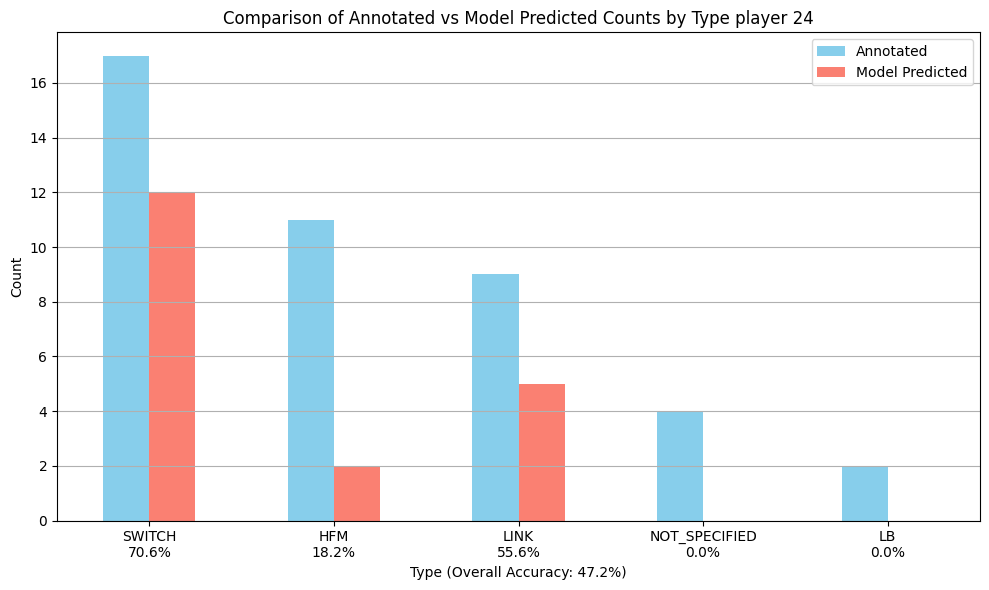

In [497]:
import pandas as pd
import matplotlib.pyplot as plt
only_24 = results_df_wide[results_df_wide["reference_player_num"] == 24]
only_24.reset_index(drop=True, inplace=True)
only_24.index = only_24.index + 1
df_filtered = only_24.drop(index=[3,6,17,20,25,30,34,40,42,44,45,47])
df_filtered.index = df_filtered.index.astype(int)

annotations = pd.read_csv("/Users/annadaugaard/Desktop/VFF/explore/spiller_24_renskrevet.csv",sep=";")
annotations["player_num"] = annotations["player_num"].astype(int)
# Merge with ground truth using to_x == player_num

merged_df = annotations.merge(df_filtered, left_on='Picture_id', right_index=True)

# Filter rows where player_num matches to_x
matching_rows2 = merged_df[merged_df["max_score_player"] == merged_df["player_num"]]
accuracy = len(matching_rows2)/len(annotations["Picture_id"].unique())


# Merge to identify matched entries by Picture_id and Type
merged = pd.merge(annotations, matching_rows2, on=["Picture_id", "Type"], suffixes=('_ann', '_pred'))

# Count occurrences per Type
annotation_counts_model = annotations["Type"].value_counts().rename("Annotated")
prediction_counts_model = merged["Type"].value_counts().rename("Model Predicted")

# Combine into one DataFrame for plotting
comparison_df_model_24 = pd.concat([annotation_counts_model, prediction_counts_model], axis=1).fillna(0)


comparison_df_model_24["Accuracy (%)"] = (comparison_df_model_24["Model Predicted"] / comparison_df_model_24["Annotated"]) * 100

# Modify the x-axis labels to include the percentage
new_labels = [f"{type_}\n{acc:.1f}%" for type_, acc in zip(comparison_df_model_24.index, comparison_df_model_24["Accuracy (%)"])]

# Calculate overall accuracy
total_annotated = comparison_df_model_24["Annotated"].sum()
total_predicted = comparison_df_model_24["Model Predicted"].sum()

overall_accuracy =  len(matching_rows2)/len(annotations["Picture_id"].unique()) * 100

# Plot with new x-axis labels and overall accuracy as xlabel
ax = comparison_df_model_24[["Annotated", "Model Predicted"]].plot(
    kind="bar", figsize=(10, 6), color=["skyblue", "salmon"]
)
ax.set_title("Comparison of Annotated vs Model Predicted Counts by Type player 24")
ax.set_xlabel(f"Type (Overall Accuracy: {overall_accuracy:.1f}%)")
ax.set_ylabel("Count")
ax.set_xticklabels(new_labels, rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# EVALUATE RESULTS PLAYER 2

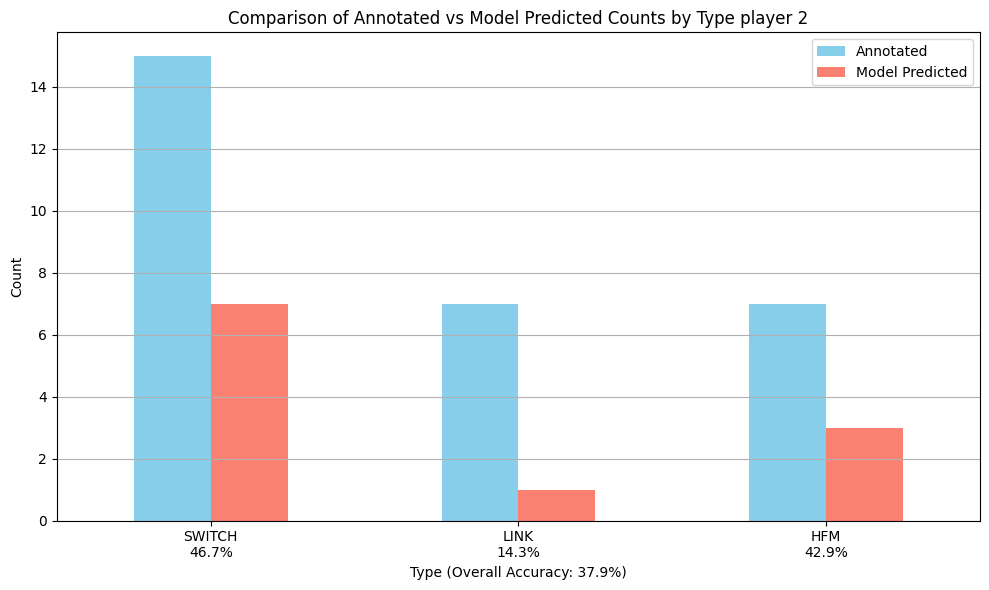

In [498]:
import pandas as pd
import matplotlib.pyplot as plt

annotations = pd.read_csv("spiller_2_renskrevet.csv",sep=";")
annotations = annotations.drop(index=5)
only_2 = results_df_wide[results_df_wide["reference_player_num"] == 2]
only_2.reset_index(drop=True, inplace=True)
only_2.index = only_2.index + 1
df_2 = only_2.drop(index=[3,5,7,17,25,30,24])
annotations = pd.read_csv("spiller_2_renskrevet.csv",sep=";")
annotations = annotations.drop(index=[5,12])
annotations["player_num"] = annotations["player_num"].astype(int)
# Merge with ground truth using to_x == player_num
merged_df = annotations.merge(df_2, left_on='Picture_id', right_index=True)
# Filter rows where player_num matches to_x
matching_rows2 = merged_df[merged_df["max_score_player"] == merged_df["player_num"]]
len(matching_rows2)/len(annotations["Picture_id"].unique())

# Filter out NaN values in annotations
annotations = annotations.dropna(subset=["Type"])

# Merge to identify matched entries by Picture_id and Type
merged = pd.merge(annotations, matching_rows2, on=["Picture_id", "Type"], suffixes=('_ann', '_pred'))

# Count occurrences per Type
annotation_counts = annotations["Type"].value_counts().rename("Annotated")
prediction_counts = merged["Type"].value_counts().rename("Model Predicted")

# Combine into one DataFrame for plotting
comparison_df_player_2_model= pd.concat([annotation_counts, prediction_counts], axis=1).fillna(0)

comparison_df_player_2_model["Accuracy (%)"] = (comparison_df_player_2_model["Model Predicted"] / comparison_df_player_2_model["Annotated"]) * 100

# Modify the x-axis labels to include the percentage
new_labels = [f"{type_}\n{acc:.1f}%" for type_, acc in zip(comparison_df_player_2_model.index, comparison_df_player_2_model["Accuracy (%)"])]

# Calculate overall accuracy
total_annotated = comparison_df_player_2_model["Annotated"].sum()
total_predicted = comparison_df_player_2_model["Model Predicted"].sum()
overall_accuracy = (total_predicted / total_annotated) * 100

# Plot with new x-axis labels and overall accuracy as xlabel
ax = comparison_df_player_2_model[["Annotated", "Model Predicted"]].plot(
    kind="bar", figsize=(10, 6), color=["skyblue", "salmon"]
)
ax.set_title("Comparison of Annotated vs Model Predicted Counts by Type player 2")
ax.set_xlabel(f"Type (Overall Accuracy: {overall_accuracy:.1f}%)")
ax.set_ylabel("Count")
ax.set_xticklabels(new_labels, rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## CALCULATING PLAYER 2 ACTUAL DECISION PERFORMANCE

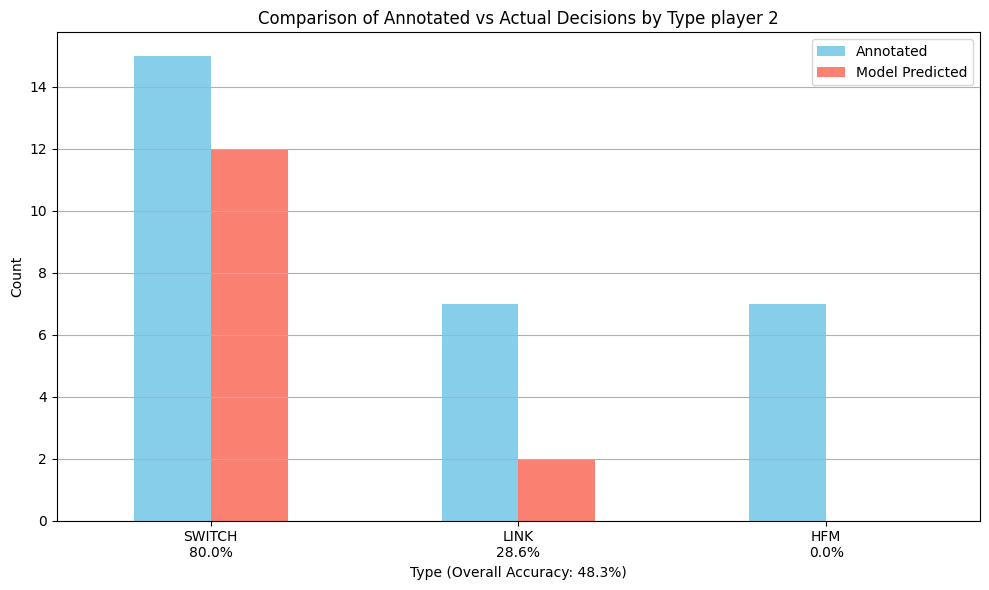

In [499]:
decision_points_2 = decision_points[decision_points["player_num"]==2]
decision_points_2.reset_index(drop=True, inplace=True)
decision_points_2.index = decision_points_2.index + 1
df_filtered_player2 = decision_points_2.drop(index=[3,5,7,17,25,30,34])

real_player2_events = pd.read_csv("/Users/annadaugaard/Desktop/VFF/deployment/tracking/test_for_streamit.csv")
pass_data_home = real_player2_events[real_player2_events["Team"] == "home"].reset_index(drop=True)
pass_data_home = pass_data_home[pass_data_home["uncertainty"] < 2].reset_index(drop=True)

annotations2 = pd.read_csv("spiller_2_renskrevet.csv",sep=";")
annotations2 = annotations2.drop(index=[12,5])
annotations2["player_num"] = annotations2["player_num"].astype(int)

merged_df = df_filtered_player2.merge(pass_data_home, left_on='pass_event_id', right_index=True)
merged_df = merged_df.drop(merged_df.columns[0], axis = 1)
merged_df["Picture_id"] = merged_df.index
final_df = annotations2.merge(merged_df, on="Picture_id", how="left")
matching_rows2 = final_df[final_df["player_num_x"] == final_df["To"]]
accuracy = len(matching_rows2)/len(annotations2["Picture_id"])


# Filter out NaN values in annotations
#annotations = annotations2.dropna(subset=["Type"])

# Merge to identify matched entries by Picture_id and Type
merged = pd.merge(annotations2, matching_rows2, on=["Picture_id", "Type"], suffixes=('_ann', '_pred'))

# Count occurrences per Type
annotation_counts = annotations2["Type"].value_counts().rename("Annotated")
prediction_counts = matching_rows2["Type"].value_counts().rename("Model Predicted")

# Combine into one DataFrame for plotting
comparison_df_player_2_decision = pd.concat([annotation_counts, prediction_counts], axis=1).fillna(0)


comparison_df_player_2_decision["Accuracy (%)"] = (comparison_df_player_2_decision["Model Predicted"] / comparison_df_player_2_decision["Annotated"]) * 100

# Modify the x-axis labels to include the percentage
new_labels = [f"{type_}\n{acc:.1f}%" for type_, acc in zip(comparison_df_player_2_decision.index, comparison_df_player_2_decision["Accuracy (%)"])]

# Calculate overall accuracy
total_annotated = comparison_df_player_2_decision["Annotated"].sum()
total_predicted = comparison_df_player_2_decision["Model Predicted"].sum()
overall_accuracy = len(matching_rows2)/len(annotations2["Picture_id"])* 100

# Plot with new x-axis labels and overall accuracy as xlabel
ax = comparison_df_player_2_decision[["Annotated", "Model Predicted"]].plot(
    kind="bar", figsize=(10, 6), color=["skyblue", "salmon"]
)
ax.set_title("Comparison of Annotated vs Actual Decisions by Type player 2")
ax.set_xlabel(f"Type (Overall Accuracy: {overall_accuracy:.1f}%)")
ax.set_ylabel("Count")
ax.set_xticklabels(new_labels, rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# PLAYER 24 ACTUAL DECISION PERFORMANCE

In [511]:
matching_rows24

,Picture_id,player_num_x,Type,preference,time,player_id,player_num_y,x,y,spd,...,Team_y,start_ball_x,start_ball_y,end_ball_x,end_ball_y,start_x_zone,start_y_zone,end_x_zone,end_y_zone,x_transition
2,2,18,SWITCH,1,98.36,45acfe4e-4812-4854-a8bb-6326c972d185,24,94.35,48.24,1.55,...,home,93.97,45.91,5.19,30.15,Attacking Third,Right Half Space,Defensive Third,Central Zone,Attacking Third -> Defensive Third
4,4,18,LINK,1,242.84,45acfe4e-4812-4854-a8bb-6326c972d185,24,91.21,61.85,2.16,...,home,88.33,62.03,80.92,64.27,Attacking Third,Right Wing,Attacking Third,Right Wing,Attacking Third -> Attacking Third
7,5,18,SWITCH,2,378.68,45acfe4e-4812-4854-a8bb-6326c972d185,24,79.65,43.94,3.85,...,home,1.82,46.75,60.22,64.14,Defensive Third,Right Half Space,Middle Third,Right Wing,Defensive Third -> Middle Third
10,8,16,NOT_SPECIFIED,1,544.40,45acfe4e-4812-4854-a8bb-6326c972d185,24,64.28,61.75,6.32,...,home,59.72,57.64,52.38,41.81,Middle Third,Right Wing,Middle Third,Right Half Space,Middle Third -> Middle Third
11,9,18,LINK,1,699.08,45acfe4e-4812-4854-a8bb-6326c972d185,24,80.31,50.57,1.83,...,home,84.77,49.81,70.49,55.63,Attacking Third,Right Half Space,Middle Third,Right Wing,Attacking Third -> Middle Third
25,23,13,LINK,1,1128.60,45acfe4e-4812-4854-a8bb-6326c972d185,24,70.23,59.16,1.81,...,home,92.48,35.90,65.89,48.26,Attacking Third,Central Zone,Middle Third,Right Half Space,Attacking Third -> Middle Third
26,24,18,SWITCH,1,1153.56,45acfe4e-4812-4854-a8bb-6326c972d185,24,59.21,33.48,3.84,...,home,74.44,58.53,40.73,64.68,Attacking Third,Right Wing,Middle Third,Right Wing,Attacking Third -> Middle Third
29,28,18,SWITCH,1,1531.12,45acfe4e-4812-4854-a8bb-6326c972d185,24,93.30,47.70,3.26,...,home,37.45,15.98,54.43,9.95,Middle Third,Left Half Space,Middle Third,Left Wing,Middle Third -> Middle Third
30,29,13,LINK,1,1555.64,45acfe4e-4812-4854-a8bb-6326c972d185,24,48.40,41.00,1.25,...,home,30.93,18.23,35.86,18.60,Defensive Third,Left Half Space,Middle Third,Left Half Space,Defensive Third -> Middle Third
34,35,16,SWITCH,1,1638.92,45acfe4e-4812-4854-a8bb-6326c972d185,24,65.25,44.19,1.16,...,home,63.11,42.81,82.14,32.91,Middle Third,Right Half Space,Attacking Third,Central Zone,Middle Third -> Attacking Third


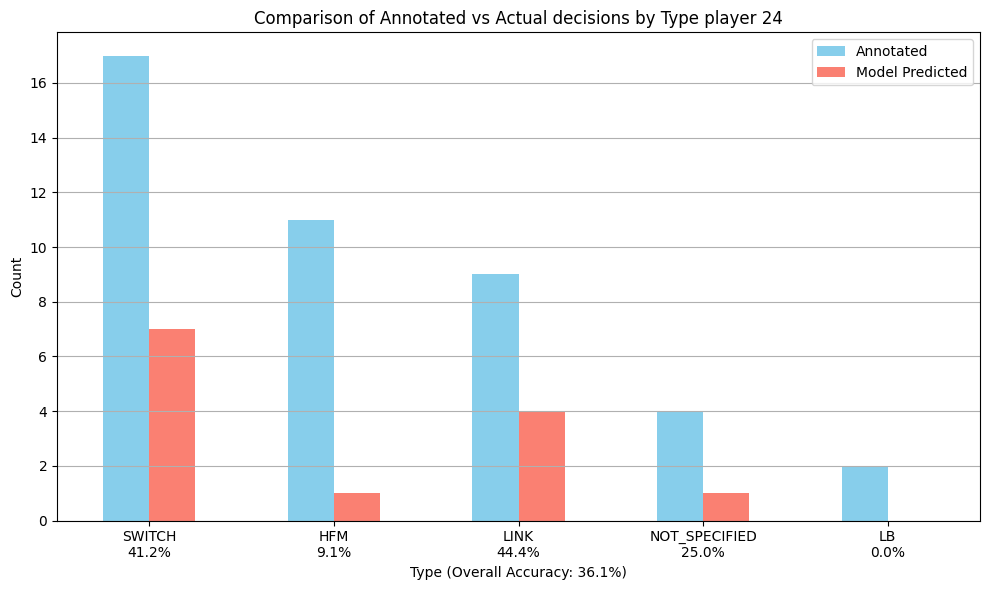

In [ ]:
decision_points_24 = decision_points[decision_points["player_num"]==24]
decision_points_24.reset_index(drop=True, inplace=True)
decision_points_24.index = decision_points_24.index + 1
df_24 = decision_points_24.drop(index=[3,6,17,20,25,30,34,40,42,44,45,47])

real_player24_events = pd.read_csv("/Users/annadaugaard/Desktop/VFF/deployment/tracking/test_for_streamit.csv")
pass_data_home = real_player24_events[real_player24_events["Team"] == "home"].reset_index(drop=True)
pass_data_home = pass_data_home[pass_data_home["uncertainty"] < 2].reset_index(drop=True)
annotations24= pd.read_csv("spiller_24_renskrevet.csv",sep=";")
annotations24["player_num"] = annotations24["player_num"].astype(int)
merged_df_24 = df_24.merge(pass_data_home, left_on='pass_event_id', right_index=True)
merged_df_24 = merged_df_24.drop(merged_df_24.columns[0], axis = 1)

merged_df_24["Picture_id"] = merged_df_24.index
final_df_24 = annotations24.merge(merged_df_24, on="Picture_id", how="left")
matching_rows24 = final_df_24[final_df_24["player_num_x"] == final_df_24["To"]]
accuracy_24 = len(matching_rows24)/len(annotations24["Picture_id"].unique())
# Merge to identify matched entries by Picture_id and Type
merged = pd.merge(annotations24, matching_rows24, on=["Picture_id", "Type"], suffixes=('_ann', '_pred'))

# Count occurrences per Type
annotation_counts_decision = annotations24["Type"].value_counts().rename("Annotated")
prediction_counts_decision = matching_rows24["Type"].value_counts().rename("Model Predicted")

# Combine into one DataFrame for plotting
comparison_df_decision_24 = pd.concat([annotation_counts_decision, prediction_counts_decision], axis=1).fillna(0)

comparison_df_decision_24["Accuracy (%)"] = (comparison_df_decision_24["Model Predicted"] / comparison_df_decision_24["Annotated"]) * 100

# Modify the x-axis labels to include the percentage
new_labels = [f"{type_}\n{acc:.1f}%" for type_, acc in zip(comparison_df_decision_24.index, comparison_df_decision_24["Accuracy (%)"])]

# Calculate overall accuracy
total_annotated = comparison_df_decision_24["Annotated"].sum()
total_predicted = comparison_df_decision_24["Model Predicted"].sum()
overall_accuracy =  len(matching_rows24)/len(annotations24["Picture_id"].unique())*100

# Plot with new x-axis labels and overall accuracy as xlabel
ax = comparison_df_decision_24[["Annotated", "Model Predicted"]].plot(
    kind="bar", figsize=(10, 6), color=["skyblue", "salmon"]
)
ax.set_title("Comparison of Annotated vs Actual decisions by Type player 24")
ax.set_xlabel(f"Type (Overall Accuracy: {overall_accuracy:.1f}%)")
ax.set_ylabel("Count")
ax.set_xticklabels(new_labels, rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


# COMPAIRSON OF MODEL AND PLAYERS


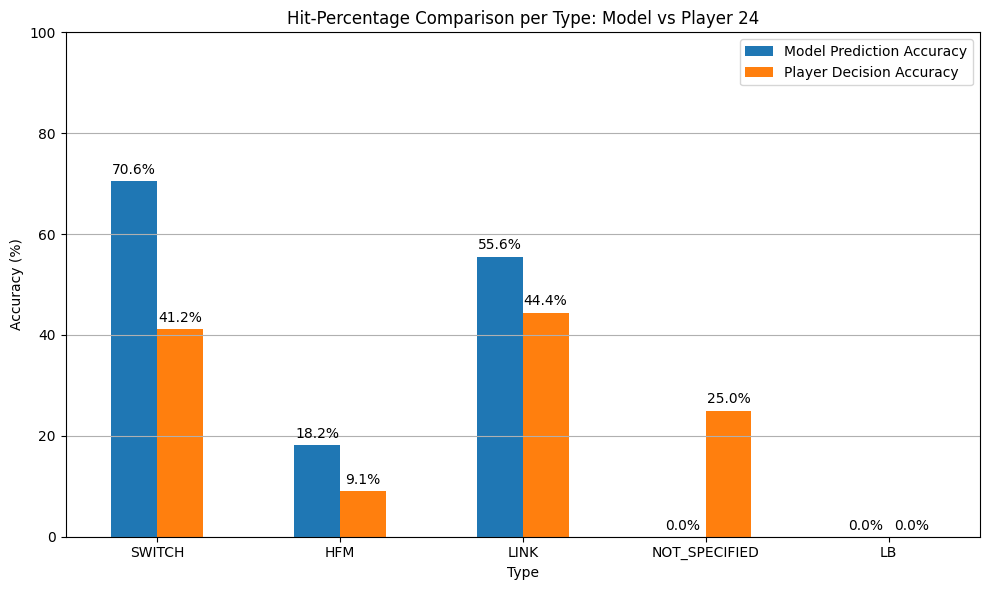

In [501]:
# Plot
accuracy_df = pd.DataFrame({
    "Model Prediction Accuracy": comparison_df_model_24["Accuracy (%)"],
    "Player Decision Accuracy": comparison_df_decision_24["Accuracy (%)"]
})
ax = accuracy_df.plot(kind='bar', figsize=(10, 6))
ax.set_title("Hit-Percentage Comparison per Type: Model vs Player 24")
ax.set_xlabel("Type")
ax.set_ylabel("Accuracy (%)")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis="y")

# Add percentage labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

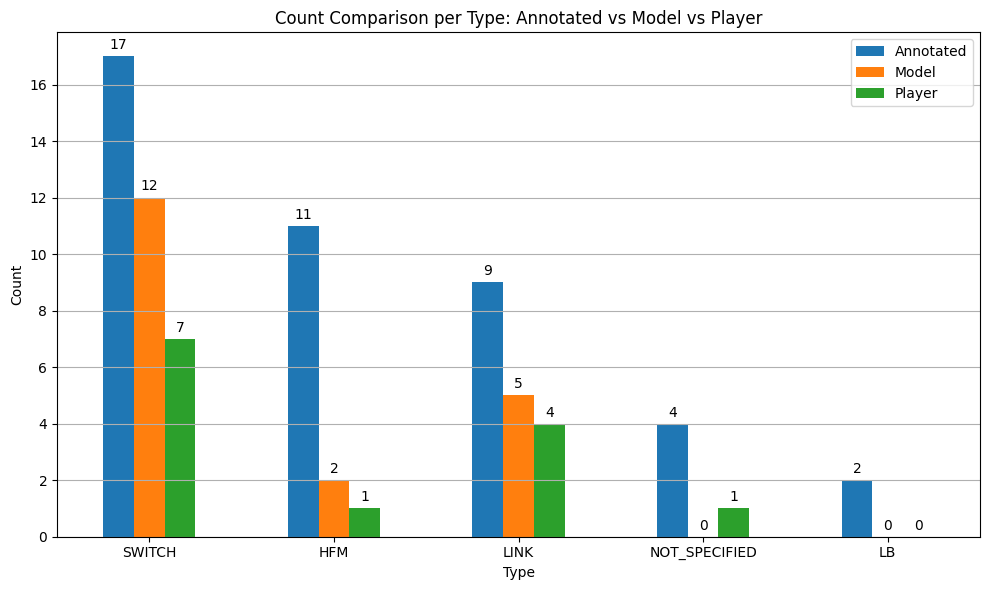

In [502]:

counts_df = pd.DataFrame({
    "Annotated": comparison_df_decision_24["Annotated"],  # same for both
    "Model": comparison_df_model_24["Model Predicted"],
    "Player": comparison_df_decision_24["Model Predicted"]
})

# Plotting
ax = counts_df.plot(kind='bar', figsize=(10, 6))
ax.set_title("Count Comparison per Type: Annotated vs Model vs Player")
ax.set_xlabel("Type")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y")

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

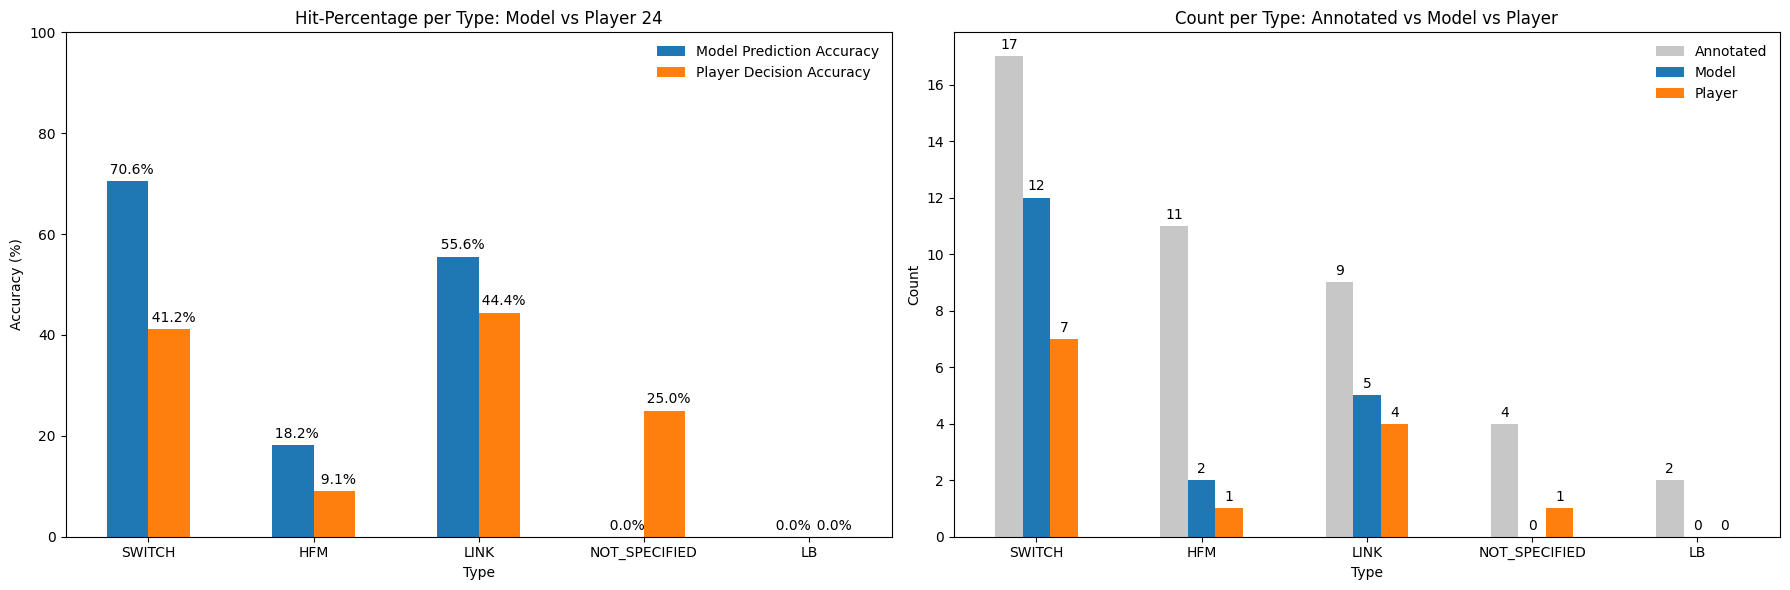

In [503]:

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
colors = {
    "Model Prediction Accuracy": "#1f77b4",  # blue
    "Player Decision Accuracy": "#ff7f0e",   # orange
    "Annotated": "#c7c7c7",                 # grey
    "Model": "#1f77b4",                     # blue
    "Player": "#ff7f0e"                     # orange
}
accuracy_df = pd.DataFrame({
    "Model Prediction Accuracy": comparison_df_model_24["Accuracy (%)"],
    "Player Decision Accuracy": comparison_df_decision_24["Accuracy (%)"]
})

accuracy_df.plot(kind='bar', ax=axes[0], color=[colors["Model Prediction Accuracy"], colors["Player Decision Accuracy"]])
axes[0].set_title("Hit-Percentage per Type: Model vs Player 24")
axes[0].set_xlabel("Type")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_ylim(0, 100)
#axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(loc="upper right", frameon=False)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='  %.1f%%', label_type='edge', padding=3)

# Count plot
counts_df = pd.DataFrame({
    "Annotated": comparison_df_decision_24["Annotated"],
    "Model": comparison_df_model_24["Model Predicted"],
    "Player": comparison_df_decision_24["Model Predicted"]
})
counts_df.plot(kind='bar', ax=axes[1], color=[colors["Annotated"], colors["Model"], colors["Player"]])
axes[1].set_title("Count per Type: Annotated vs Model vs Player")
axes[1].set_xlabel("Type")
axes[1].set_ylabel("Count")
#axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(loc="upper right", frameon=False)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

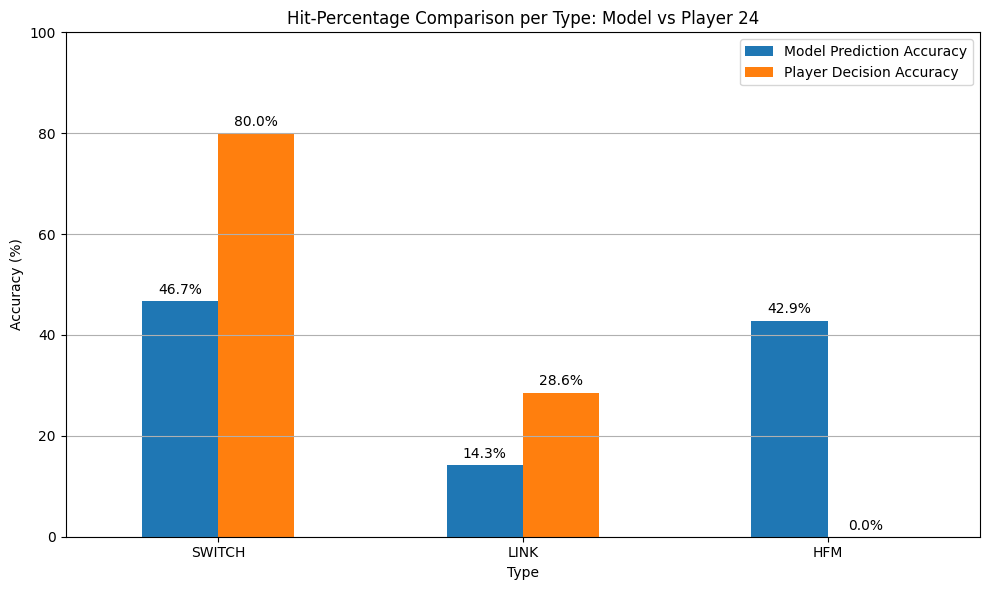

In [504]:
# Plot
accuracy_df = pd.DataFrame({
    "Model Prediction Accuracy": comparison_df_player_2_model["Accuracy (%)"],
    "Player Decision Accuracy": comparison_df_player_2_decision["Accuracy (%)"]
})
ax = accuracy_df.plot(kind='bar', figsize=(10, 6))
ax.set_title("Hit-Percentage Comparison per Type: Model vs Player 24")
ax.set_xlabel("Type")
ax.set_ylabel("Accuracy (%)")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis="y")

# Add percentage labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

In [505]:
comparison_df_player_2_decision

,Annotated,Model Predicted,Accuracy (%)
Type,,,
SWITCH,15,12.0,80.000000
LINK,7,2.0,28.571429
HFM,7,0.0,0.000000


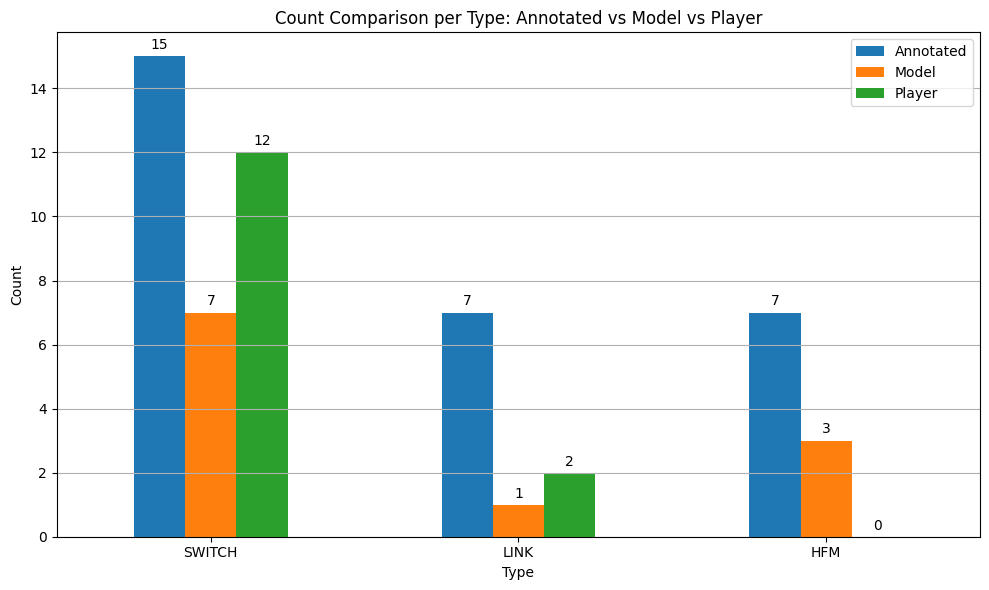

In [506]:

counts_df = pd.DataFrame({
    "Annotated": comparison_df_player_2_decision["Annotated"],  # same for both
    "Model": comparison_df_player_2_model["Model Predicted"],
    "Player": comparison_df_player_2_decision["Model Predicted"]
})

# Plotting
ax = counts_df.plot(kind='bar', figsize=(10, 6))
ax.set_title("Count Comparison per Type: Annotated vs Model vs Player")
ax.set_xlabel("Type")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y")

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

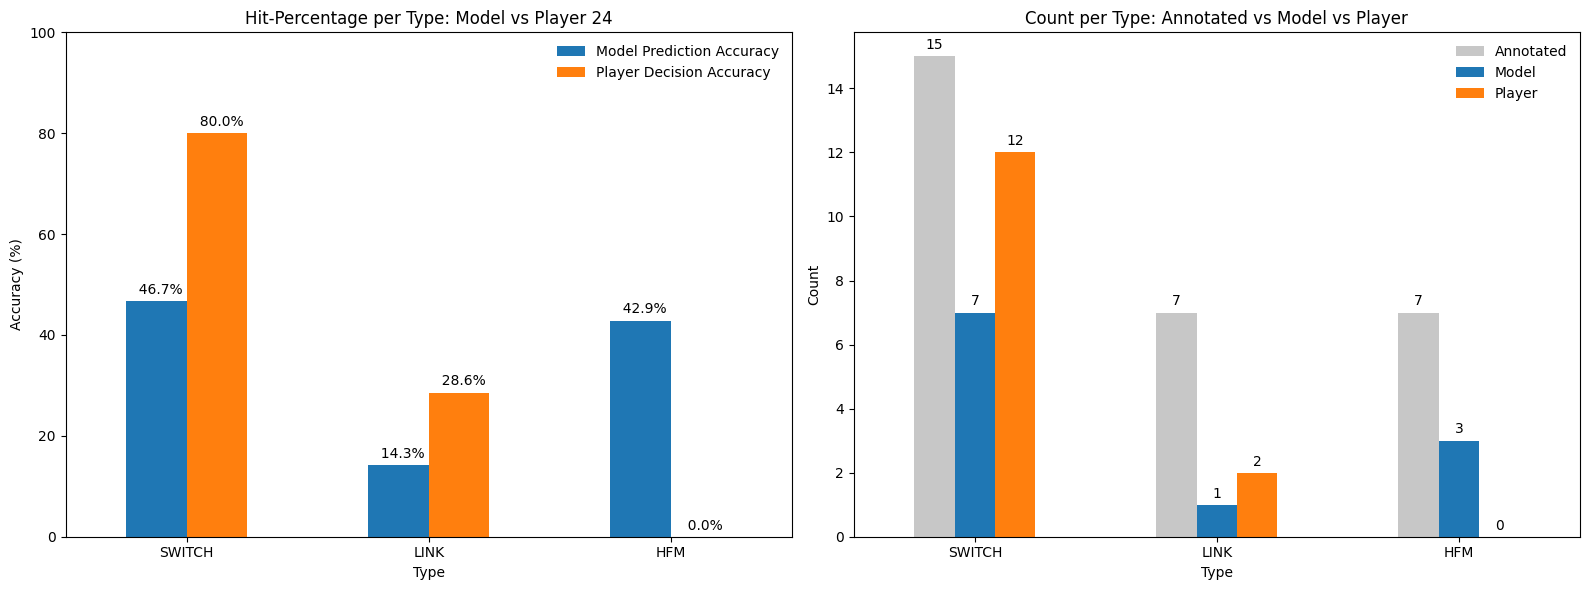

In [507]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

accuracy_df = pd.DataFrame({
    "Model Prediction Accuracy": comparison_df_player_2_model["Accuracy (%)"],
    "Player Decision Accuracy": comparison_df_player_2_decision["Accuracy (%)"]
})


colors = {
    "Model Prediction Accuracy": "#1f77b4",  # blue
    "Player Decision Accuracy": "#ff7f0e",   # orange
    "Annotated": "#c7c7c7",                 # grey
    "Model": "#1f77b4",                     # blue
    "Player": "#ff7f0e"                     # orange
}


accuracy_df.plot(kind='bar', ax=axes[0], color=[colors["Model Prediction Accuracy"], colors["Player Decision Accuracy"]])
axes[0].set_title("Hit-Percentage per Type: Model vs Player 24")
axes[0].set_xlabel("Type")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_ylim(0, 100)
#axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(loc="upper right", frameon=False)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='  %.1f%%', label_type='edge', padding=3)

# Count plot
counts_df = pd.DataFrame({
    "Annotated": comparison_df_player_2_decision["Annotated"],
    "Model": comparison_df_player_2_model["Model Predicted"],
    "Player": comparison_df_player_2_decision["Model Predicted"]
})
counts_df.plot(kind='bar', ax=axes[1], color=[colors["Annotated"], colors["Model"], colors["Player"]])
axes[1].set_title("Count per Type: Annotated vs Model vs Player")
axes[1].set_xlabel("Type")
axes[1].set_ylabel("Count")
#axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(loc="upper right", frameon=False)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()